### 인공신경망 구현

* 필요한 기능 import

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

* 런타임 유형 변경 전

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


* 런타임 유형 변경 후

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


* 재현 위한 시드 설정

In [ ]:
random.seed(777)
torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

**Model code**

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    return self.model(x)

**Training code**

In [ ]:
# hyperparameters
training_epochs = 3
batch_size = 100

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True)

# MLP 객체 생성
model = MLP().to(device)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for idx, (x_train, y_train) in enumerate(data_loader):
    x_train = x_train.view(-1, 28*28).to(device)
    y_train = y_train.to(device)

    outputs = model(x_train)
    cost = criterion(outputs, y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch

  print('Epoch:', '%04d'%(epoch+1), 'cost=', '{:.9f}'.format(avg_cost))

print("Learning finished")

Epoch: 0001 cost= 0.244625121
Epoch: 0002 cost= 0.129792050
Epoch: 0003 cost= 0.111835487
Learning finished


**Test code**

In [ ]:
with torch.no_grad():
  x_test = mnist_test.data.view(-1, 28*28).float().to(device)
  y_test = mnist_test.targets.to(device)

  prediction = model(x_test)
  correct_prediction = torch.argmax(prediction, 1) == y_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.9660999774932861


tensor([ 115,  149,  241,  247,  259,  266,  321,  340,  352,  366,  432,  435,
         445,  447,  448,  449,  495,  582,  613,  619,  654,  659,  684,  707,
         716,  717,  740,  760,  786,  810,  829,  839,  844,  881,  947,  951,
         956,  959,  965, 1014, 1039, 1044, 1107, 1112, 1147, 1173, 1178, 1181,
        1224, 1226, 1232, 1242, 1247, 1248, 1260, 1289, 1299, 1315, 1319, 1326,
        1328, 1356, 1378, 1393, 1466, 1476, 1522, 1523, 1525, 1527, 1530, 1549,
        1553, 1571, 1609, 1678, 1681, 1686, 1689, 1691, 1709, 1737, 1751, 1754,
        1800, 1850, 1878, 1941, 1952, 1955, 1963, 2004, 2024, 2035, 2053, 2093,
        2098, 2109, 2129, 2130, 2135, 2174, 2182, 2186, 2189, 2291, 2293, 2369,
        2380, 2381, 2387, 2405, 2422, 2447, 2488, 2514, 2515, 2573, 2578, 2582,
        2607, 2645, 2648, 2654, 2670, 2721, 2758, 2770, 2810, 2850, 2877, 2896,
        2921, 2939, 2953, 2970, 2998, 3005, 3012, 3030, 3060, 3073, 3112, 3130,
        3166, 3172, 3225, 3333, 3422, 34

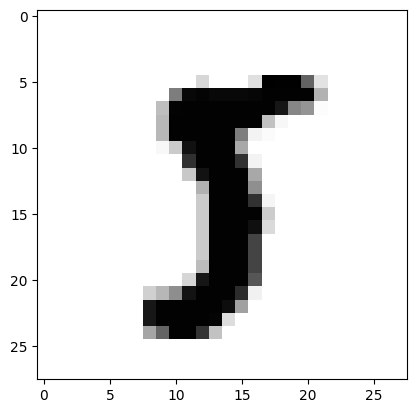

In [ ]:
with torch.no_grad():
  wrong_indices = (correct_prediction == 0).nonzero(as_tuple=True)[0]
  print(wrong_indices)
  r = random.randint(0, len(wrong_indices)-1)
  r = wrong_indices[r].cpu().item()
  x_single_data = mnist_test.data[r:r+1].view(-1,28*28).float().cuda()
  y_single_data = mnist_test.targets[r:r+1].cuda()

  print('Label: ', y_single_data.item())
  single_prediction = model(x_single_data)
  print('Prediction: ', torch.argmax(single_prediction, 1).item())

  plt.imshow(mnist_test.data[r:r+1].view(28,28), cmap='Greys', interpolation='nearest')
  plt.show()

Q. **wrong_indices = (correct_prediction == 0).nonzero(as_tuple=True)[0]** 여기서 [0]을 붙이는 이유

A. 텐서가 튜플에 감싸져있기 때문임.

In [ ]:
(correct_prediction == 0).nonzero(as_tuple=True)

(tensor([ 115,  149,  241,  247,  259,  266,  321,  340,  352,  366,  432,  435,
          445,  447,  448,  449,  495,  582,  613,  619,  654,  659,  684,  707,
          716,  717,  740,  760,  786,  810,  829,  839,  844,  881,  947,  951,
          956,  959,  965, 1014, 1039, 1044, 1107, 1112, 1147, 1173, 1178, 1181,
         1224, 1226, 1232, 1242, 1247, 1248, 1260, 1289, 1299, 1315, 1319, 1326,
         1328, 1356, 1378, 1393, 1466, 1476, 1522, 1523, 1525, 1527, 1530, 1549,
         1553, 1571, 1609, 1678, 1681, 1686, 1689, 1691, 1709, 1737, 1751, 1754,
         1800, 1850, 1878, 1941, 1952, 1955, 1963, 2004, 2024, 2035, 2053, 2093,
         2098, 2109, 2129, 2130, 2135, 2174, 2182, 2186, 2189, 2291, 2293, 2369,
         2380, 2381, 2387, 2405, 2422, 2447, 2488, 2514, 2515, 2573, 2578, 2582,
         2607, 2645, 2648, 2654, 2670, 2721, 2758, 2770, 2810, 2850, 2877, 2896,
         2921, 2939, 2953, 2970, 2998, 3005, 3012, 3030, 3060, 3073, 3112, 3130,
         3166, 3172, 3225, 3